In [1]:
import argparse
import json
import os
import matplotlib.pyplot as plt
import torch
import yaml
from dataloader import ZFSliceDataset, SimulatedDataset, SimulatedSPFDataset
from einops import rearrange
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from transform import VideoRotate, VideoDiffeo, SubsampleTime, MonophasicTimeWarp, TemporalNoise, TimeReverse
from ei import EILoss
from mc import MCLoss
from lsfpnet_encoding import LSFPNet, ArtifactRemovalLSFPNet
from radial_lsfp import MCNUFFT
from utils import prep_nufft, log_gradient_stats, plot_enhancement_curve, get_cosine_ei_weight, plot_reconstruction_sample, get_git_commit, save_checkpoint, load_checkpoint, to_torch_complex, GRASPRecon, sliding_window_inference, set_seed
from eval import eval_grasp, eval_sample

In [16]:
grasp_img = np.load('/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_040_sub40/grasp_spf2_frames144.npy')
print(grasp_img.shape)

(144, 320, 320)


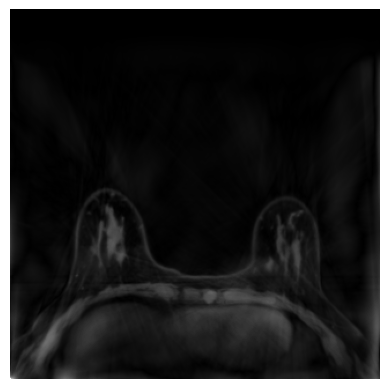

In [17]:
plt.axis("off")
plt.imshow(np.abs(grasp_img[0]), cmap="gray")

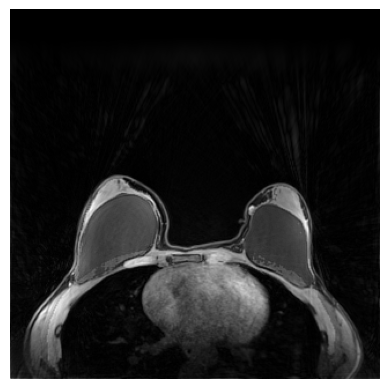

In [ ]:
fs_grasp_img = np.load('/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_031_sub30/grasp_spf36_frames8.npy')

plt.axis("off")
plt.imshow(np.abs(fs_grasp_img[0]), cmap="gray")

In [11]:
# load data
split_file = "/gpfs/data/karczmar-lab/workspaces/rachelgordon/breastMRI-recon/ddei/data/data_split.json"
with open(split_file, "r") as fp:
    splits = json.load(fp)

val_patient_ids = splits["val"]
val_dro_patient_ids = splits["val_dro"]

In [12]:
root_dir = "/ess/scratch/scratch1/rachelgordon/dro_dataset"
model_type = "LSFPNet"

eval_spf_dataset = SimulatedSPFDataset(
    root_dir=root_dir, 
    model_type=model_type, 
    patient_ids=val_dro_patient_ids,
    )


eval_spf_loader = DataLoader(
    eval_spf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_18frames for 18 frames.


In [13]:
device = torch.device("cuda")
N_samples = 640
exp_name = "plot_grasp_metrics"
output_dir = os.path.join("output", exp_name)
eval_dir = os.path.join(output_dir, "eval_results")

In [14]:
MAIN_EVALUATION_PLAN = [
            {
                "spokes_per_frame": 2,
                "num_frames": 144, # 2 * 144 = 288 total spokes
                "description": "Stress test: max temporal points, 2 spokes"
            },
            {
                "spokes_per_frame": 4,
                "num_frames": 72, # 4 * 72 = 288 total spokes
                "description": "Stress test: max temporal points, 4 spokes"
            },
            {
                "spokes_per_frame": 8,
                "num_frames": 36, # 8 * 36 = 288 total spokes
                "description": "High temporal resolution"
            },
            {
                "spokes_per_frame": 16,
                "num_frames": 18, # 16 * 18 = 288 total spokes
                "description": "High temporal resolution"
            },
            {
                "spokes_per_frame": 24,
                "num_frames": 12, # 24 * 12 = 288 total spokes
                "description": "Good temporal resolution"
            },
            {
                "spokes_per_frame": 32,
                "num_frames": 8, # 36 * 8 = 288 total spokes
                "description": "Standard temporal resolution"
            },
        ]

In [15]:
spf_grasp_ssim = {}
spf_grasp_psnr = {}
spf_grasp_mse = {}
spf_grasp_lpips = {}
spf_grasp_dc_mse = {}
spf_grasp_dc_mae = {}
spf_grasp_corr = {}
spf_raw_dc_mse = {}
spf_raw_dc_mae = {}
spf_raw_grasp_dc_mse = {}
spf_raw_grasp_dc_mae = {}

for eval_config in MAIN_EVALUATION_PLAN:
                
                stress_test_grasp_ssims = []
                stress_test_grasp_psnrs = []
                stress_test_grasp_mses = []
                stress_test_grasp_lpipses = []
                stress_test_grasp_dc_mses = []
                stress_test_grasp_dc_maes = []
                stress_test_grasp_corrs = []

                spokes = eval_config["spokes_per_frame"]
                num_frames = eval_config["num_frames"]

                eval_spf_dataset.spokes_per_frame = spokes
                eval_spf_dataset.num_frames = num_frames
                eval_spf_dataset._update_sample_paths()


                
                for csmap, ground_truth, grasp_img, mask, grasp_path in eval_spf_loader:

                    print("grasp_path: ", grasp_path)


                    csmap = csmap.squeeze(0).to(device)   # Remove batch dim
                    ground_truth = ground_truth.to(device) # Shape: (1, 2, T, H, W)

                    # SIMULATE KSPACE
                    ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, spokes, num_frames)
                    physics = MCNUFFT(nufft_ob.to(device), adjnufft_ob.to(device), ktraj.to(device), dcomp.to(device))

                    sim_kspace = physics(False, ground_truth, csmap)

                    kspace = sim_kspace.squeeze(0).to(device) # Remove batch dim


                    # check if GRASP image exists or if we need to perform GRASP recon
                    # if type(grasp_img) is int or len(grasp_img.shape) == 1:
                    #     print(f"No GRASP file found, performing reconstruction with {spokes} spokes/frame and {num_frames} frames.")

                    #     grasp_img = GRASPRecon(csmap, sim_kspace, spokes, num_frames, grasp_path[0])

                    #     grasp_recon_torch = torch.from_numpy(grasp_img).permute(2, 0, 1) # T, H, W
                    #     grasp_recon_torch = torch.stack([grasp_recon_torch.real, grasp_recon_torch.imag], dim=0)

                    #     grasp_img = torch.flip(grasp_recon_torch, dims=[-3])
                    #     grasp_img = torch.rot90(grasp_img, k=3, dims=[-3,-1]).unsqueeze(0)

                    grasp_img = grasp_img.to(device)

                    ground_truth = torch.stack([ground_truth.real, ground_truth.imag], dim=1)
                    ground_truth = rearrange(ground_truth, 'b i h w t -> b i t h w')


                    ## Evaluation
                    # ssim, psnr, mse, lpips, dc_mse, dc_mae, recon_corr, grasp_corr = eval_sample(kspace, csmap, ground_truth, x_recon, physics, mask, grasp_img, acceleration, int(spokes), eval_dir, f"{spokes}spf", device)
                    # stress_test_ssims.append(ssim)
                    # stress_test_psnrs.append(psnr)
                    # stress_test_mses.append(mse)
                    # stress_test_lpipses.append(lpips)
                    # stress_test_dc_mses.append(dc_mse)
                    # stress_test_dc_maes.append(dc_mae)

                    # if recon_corr is not None:
                    #     stress_test_corrs.append(recon_corr)
                    #     stress_test_grasp_corrs.append(grasp_corr)


                    ssim_grasp, psnr_grasp, mse_grasp, lpips_grasp, dc_mse_grasp, dc_mae_grasp = eval_grasp(kspace, csmap, ground_truth, grasp_img, physics, device, eval_dir)

                    stress_test_grasp_ssims.append(ssim_grasp)
                    stress_test_grasp_psnrs.append(psnr_grasp)
                    stress_test_grasp_mses.append(mse_grasp)
                    stress_test_grasp_lpipses.append(lpips_grasp)
                    stress_test_grasp_dc_mses.append(dc_mse_grasp)
                    stress_test_grasp_dc_maes.append(dc_mae_grasp)

                spf_grasp_ssim[spokes] = np.mean(stress_test_grasp_ssims)
                spf_grasp_psnr[spokes] = np.mean(stress_test_grasp_psnrs)
                spf_grasp_mse[spokes] = np.mean(stress_test_grasp_mses)
                spf_grasp_lpips[spokes] = np.mean(stress_test_grasp_lpipses)
                spf_grasp_dc_mse[spokes] = np.mean(stress_test_grasp_dc_mses)
                spf_grasp_dc_mae[spokes] = np.mean(stress_test_grasp_dc_maes)
                spf_grasp_corr[spokes] = np.mean(stress_test_grasp_corrs)



                    # spf_grasp_ssim[spokes] = np.mean(stress_test_grasp_ssims)
                    # spf_grasp_psnr[spokes] = np.mean(stress_test_grasp_psnrs)
                    # spf_grasp_mse[spokes] = np.mean(stress_test_grasp_mses)
                    # spf_grasp_lpips[spokes] = np.mean(stress_test_grasp_lpipses)
                    # spf_grasp_dc_mse[spokes] = np.mean(stress_test_grasp_dc_mses)
                    # spf_grasp_dc_mae[spokes] = np.mean(stress_test_grasp_dc_maes)
                    # spf_grasp_corr[spokes] = np.mean(stress_test_grasp_corrs)

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames for 144 frames.


  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_005_sub5  Testing 2 spokes/frame with 144 frames.

loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_007_sub7
  Testing 2 spokes/frame with 144 frames.
  Testing 2 spokes/frame with 144 frames.loading data from 
 /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_020_sub20loading data from 
 /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_012_sub12
  Testing 2 spokes/frame with 144 frames.
loading data from   Testing 2 spokes/frame with 144 frames. 
/ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_030_sub30loading data from 
 /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_032_sub32
  Testing 2 spokes/frame with 144 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames/sample_031_sub31
  Testing 2 spokes/frame with

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd6a122aa20>
Traceback (most recent call last):
  File "/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/data/karczmar-lab/workspaces/rachelgordon/micromamba/envs/recon_mri/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [17]:
from raw_kspace_eval import eval_raw_kspace


spf_grasp_ssim = {}
spf_grasp_psnr = {}
spf_grasp_mse = {}
spf_grasp_lpips = {}
spf_grasp_dc_mse = {}
spf_grasp_dc_mae = {}
spf_grasp_corr = {}
spf_raw_dc_mse = {}
spf_raw_dc_mae = {}
spf_raw_grasp_dc_mse = {}
spf_raw_grasp_dc_mae = {}

for eval_config in MAIN_EVALUATION_PLAN:
                
                stress_test_grasp_ssims = []
                stress_test_grasp_psnrs = []
                stress_test_grasp_mses = []
                stress_test_grasp_lpipses = []
                stress_test_grasp_dc_mses = []
                stress_test_grasp_dc_maes = []
                stress_test_grasp_corrs = []

                spokes = eval_config["spokes_per_frame"]
                num_frames = eval_config["num_frames"]

                eval_spf_dataset.spokes_per_frame = spokes
                eval_spf_dataset.num_frames = num_frames
                eval_spf_dataset._update_sample_paths()

                # evaluate on raw k-space
                num_slices_to_eval = 1
                print(f"Evaluating on raw k-space with {num_slices_to_eval} slices...")
                raw_dc_mse, raw_dc_mae, raw_grasp_dc_mse, raw_grasp_dc_mae, raw_dc_std_mse, raw_dc_std_mae, raw_dc_std_grasp_mse, raw_dc_std_grasp_mae = eval_raw_kspace(num_slices_to_eval, val_patient_ids, data_dir, model, spokes, N_slices, num_frames, eval_chunk_size, eval_chunk_overlap, H, W, ktraj, dcomp, nufft_ob, adjnufft_ob, physics, acceleration_encoding, start_timepoint_index, device, output_dir, label=f"{spokes}spf")

                spf_raw_dc_mse[spokes] = raw_dc_mse
                spf_raw_dc_mae[spokes] = raw_dc_mae
                spf_raw_grasp_dc_mse[spokes] = raw_grasp_dc_mse
                spf_raw_grasp_dc_mae[spokes] = raw_grasp_dc_mae

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_144frames for 144 frames.
Evaluating on raw k-space with 1 slices...


NameError: name 'data_dir' is not defined

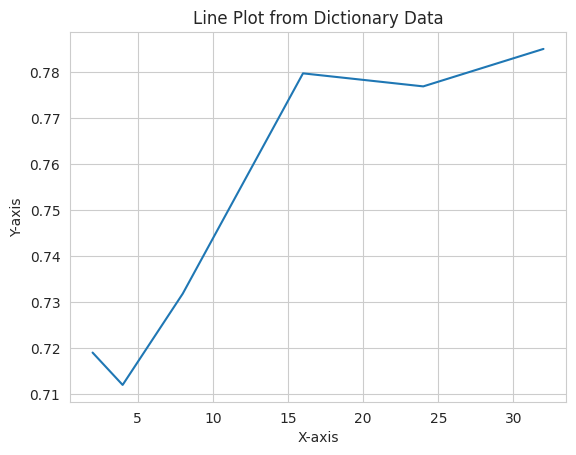

In [24]:
import seaborn as sns

# Create the line plot
sns.lineplot(x=list(spf_grasp_ssim.keys()), y=list(spf_grasp_ssim.values()))

plt.title("Line Plot from Dictionary Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

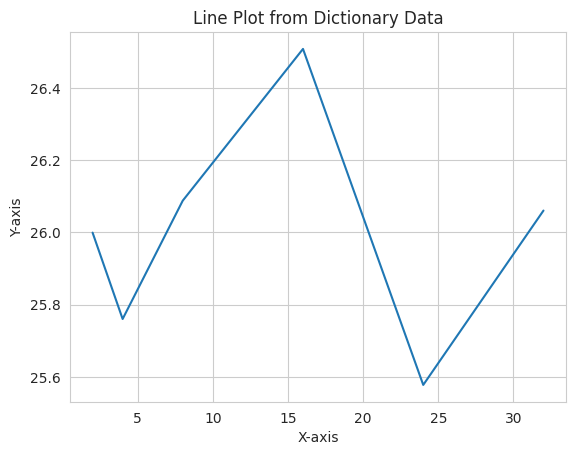

In [25]:
# Create the line plot
sns.lineplot(x=list(spf_grasp_psnr.keys()), y=list(spf_grasp_psnr.values()))

plt.title("Line Plot from Dictionary Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

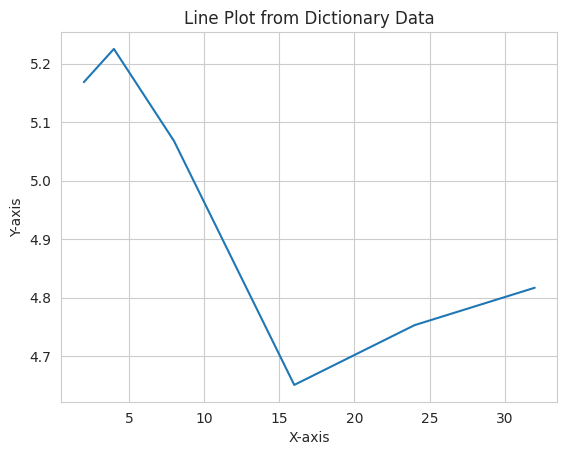

In [ ]:
# Create the line plot
sns.lineplot(x=list(spf_grasp_mse.keys())[:4], y=list(spf_grasp_mse.values())[:4])

plt.title("Line Plot from Dictionary Data")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [42]:
import math

N_full = 320 * math.pi / 2

acceleration_lpips = {}
for spf in spf_grasp_lpips.keys():

    acceleration = N_full / int(spf)
    acceleration_lpips[acceleration] = spf_grasp_lpips[spf]

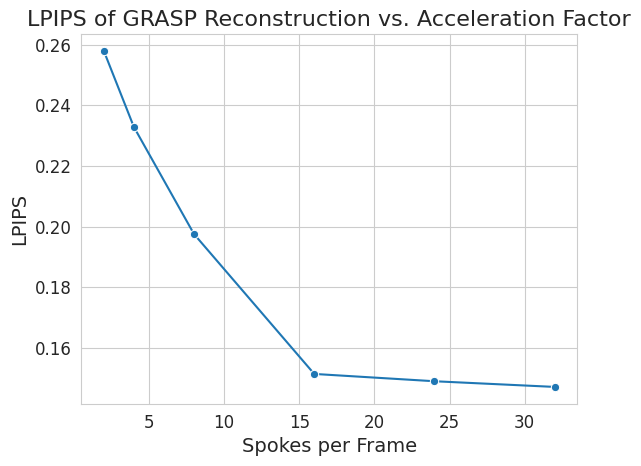

In [38]:
# Create the line plot
sns.lineplot(x=list(spf_grasp_lpips.keys()), y=list(spf_grasp_lpips.values()), marker='o')

plt.title('LPIPS of GRASP Reconstruction vs. Acceleration Factor', fontsize=16)
plt.xlabel("Spokes per Frame", fontsize=14)
plt.ylabel("LPIPS", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True) # Add a grid for better readability

plt.show()

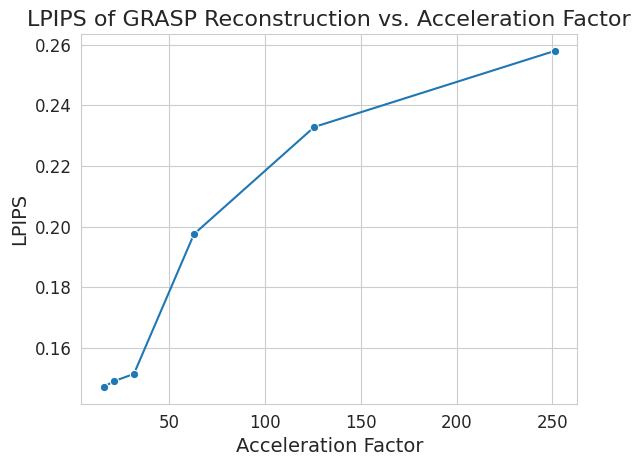

In [44]:
# Create the line plot
sns.lineplot(x=list(acceleration_lpips.keys()), y=list(acceleration_lpips.values()), marker='o')

plt.title('LPIPS of GRASP Reconstruction vs. Acceleration Factor', fontsize=16)
plt.xlabel("Acceleration Factor", fontsize=14)
plt.ylabel("LPIPS", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True) # Add a grid for better readability

plt.show()